In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import shap
import time
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score,confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,brier_score_loss,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE,RFECV

In [2]:
os.chdir("/Users/weiyuna/Desktop/工作/合作项目/上海胸科/20211103导出数据/房颤/补充结局-不包含瓣膜手术")

In [3]:
data = pd.read_csv("data_imputation_full.csv")

In [4]:
features_outcome = data.columns[2:5]

In [5]:
features_include = data.columns[5:65]

In [6]:
X = data[features_include]
Y = data[features_outcome]

In [7]:
## 随机拆分训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)

In [8]:
Y1_train = Y_train["outcome"]
Y2_train = Y_train["outcome_h"]
Y3_train = Y_train["outcome_b"]
Y1_test = Y_test["outcome"]
Y2_test = Y_test["outcome_h"]
Y3_test = Y_test["outcome_b"]

In [9]:
Y1_test.value_counts()

0    991
1     19
Name: outcome, dtype: int64

In [37]:
gbm_cv_parameters = {'learning_rate':[0.001,0.005,0.01,0.05,0.1], # 5
                     'n_estimators':[50,100,200,300],  # 4
                    'max_depth':[3,5,7,10], # 4
                     'min_samples_split':[2,5,10,20,50], # 5
                    'min_samples_leaf':[2,5,10,20,50], # 5
                     'subsample':[0.5,0.7,0.9], # 3
                     'max_features':[5,10,15,20],  # 4
                     'random_state':[123]}

st = time.time()
gbm = GradientBoostingClassifier()
gbm_gs1 = GridSearchCV(gbm, param_grid = gbm_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
gbm_gs1.fit(X_train,Y1_train)

# 性能测评
print("参数的最佳取值：:", gbm_gs1.best_params_)
print("最佳模型得分:", gbm_gs1.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))

参数的最佳取值：: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 123, 'subsample': 0.5}
最佳模型得分: 0.7523195265607717
耗时: 48148.421056985855 s


In [10]:
gbm1 = GradientBoostingClassifier(learning_rate=0.01, max_depth=10, max_features=15,min_samples_leaf=2, 
                                  min_samples_split=2,n_estimators=100, random_state=123, subsample=0.5).fit(X_train,Y1_train)

In [11]:
explainer1 = shap.TreeExplainer(gbm1)
shap_values1 = explainer1(X_train)

In [12]:
shap_values1.values.shape

(2355, 60)

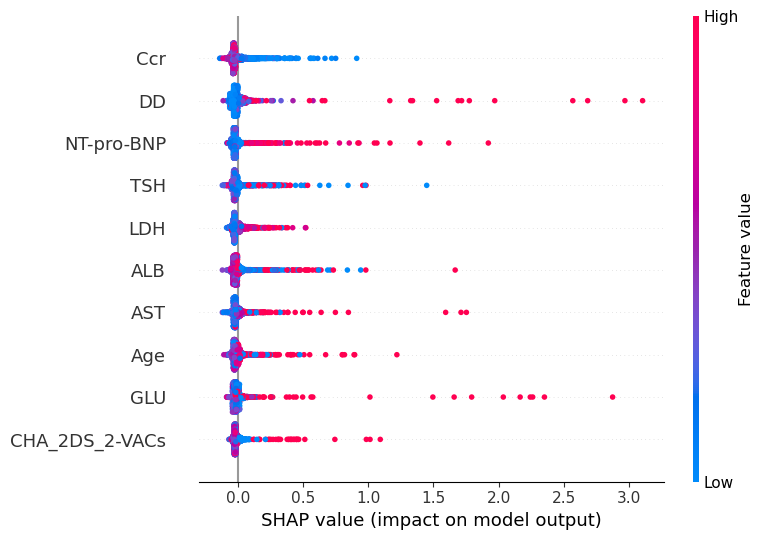

In [13]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values1,X_train,plot_type="dot",max_display=10,show=False)

In [14]:
def get_shap_top_n(shap_value,n):
    fea_imp = pd.DataFrame()
    fea_imp["feature_name"] = X_train.columns
    fea_imp["shap_value"] = np.sum(np.abs(shap_value.values),axis=0)
    fea_imp.sort_values("shap_value",ascending=False,inplace=True)
    return fea_imp[0:n].feature_name.values

In [15]:
def get_shap_values(shap_value):
    fea_imp = pd.DataFrame()
    fea_imp["feature_name"] = X_train.columns
    fea_imp["shap_value"] = np.sum(np.abs(shap_value.values),axis=0)
    fea_imp.sort_values("shap_value",ascending=False,inplace=True)
    return fea_imp

In [16]:
# get_shap_values(shap_values1).to_csv("gbm1_shap.csv")
# get_shap_values(shap_values2).to_csv("gbm2_shap.csv")
# get_shap_values(shap_values3).to_csv("gbm3_shap.csv")

In [17]:
get_shap_top_n(shap_values1,10)

array(['Ccr', 'DD', 'NT-pro-BNP', 'TSH', 'LDH', 'ALB', 'AST', 'Age',
       'GLU', 'CHA_2DS_2-VACs'], dtype=object)

In [38]:
gbm_cv_parameters = {'learning_rate':[0.001,0.005,0.01,0.05,0.1], # 5
                     'n_estimators':[50,100,200,300],  # 4
                    'max_depth':[3,5,7,10], # 4
                     'min_samples_split':[2,5,10,20,50], # 5
                    'min_samples_leaf':[2,5,10,20,50], # 5
                     'subsample':[0.5,0.7,0.9], # 3
                     'max_features':[5,10,15,20],  # 4
                     'random_state':[123]}

st = time.time()
gbm = GradientBoostingClassifier()
gbm_gs2 = GridSearchCV(gbm, param_grid = gbm_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
gbm_gs2.fit(X_train,Y2_train)

# 性能测评
print("参数的最佳取值：:", gbm_gs2.best_params_)
print("最佳模型得分:", gbm_gs2.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))

参数的最佳取值：: {'learning_rate': 0.01, 'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 123, 'subsample': 0.7}
最佳模型得分: 0.8101041891413173
耗时: 77348.43568611145 s


In [18]:
gbm2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=10,min_samples_leaf=5, 
                                  min_samples_split=20,n_estimators=100, random_state=123, subsample=0.7).fit(X_train,Y2_train)

In [19]:
explainer2 = shap.TreeExplainer(gbm2)
shap_values2 = explainer2(X_train)

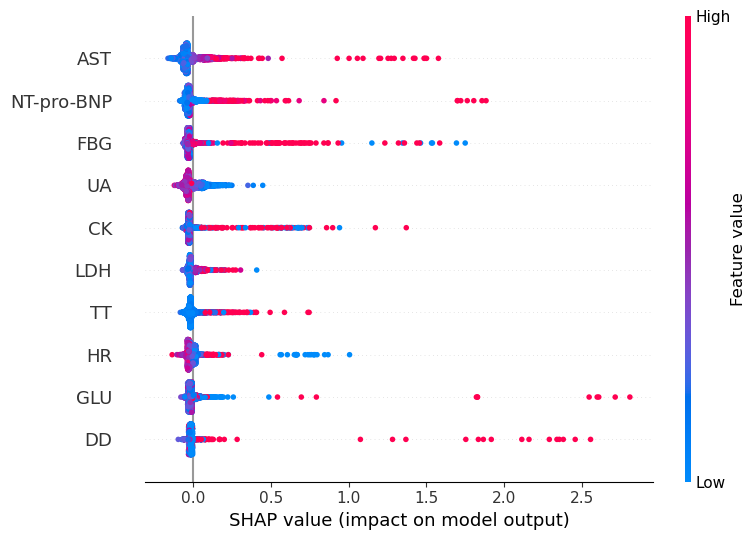

In [20]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values2,X_train,plot_type="dot",max_display=10,show=False)

In [21]:
get_shap_top_n(shap_values2,5)

array(['AST', 'NT-pro-BNP', 'FBG', 'UA', 'CK'], dtype=object)

In [22]:
gbm_cv_parameters = {'learning_rate':[0.001,0.005,0.01,0.05], # 4
                     'n_estimators':[50,100,200,300],  # 4
                    'max_depth':[3,5,7,10], # 4
                     'min_samples_split':[2,5,10,20,50], # 5
                    'min_samples_leaf':[2,5,10,20,50], # 5
                     'subsample':[0.5,0.7,0.9], # 3
                     'max_features':[5,10,15,20],  # 4
                     'random_state':[123]}

st = time.time()
gbm = GradientBoostingClassifier()
gbm_gs3 = GridSearchCV(gbm, param_grid = gbm_cv_parameters,cv=3, n_jobs=-1,scoring="roc_auc")
gbm_gs3.fit(X_train,Y3_train)

# 性能测评
print("参数的最佳取值：:", gbm_gs3.best_params_)
print("最佳模型得分:", gbm_gs3.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))

In [22]:
gbm3 = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=10,min_samples_leaf=5, 
                                  min_samples_split=20,n_estimators=100, random_state=123, subsample=0.7).fit(X_train,Y3_train)

In [23]:
explainer3 = shap.TreeExplainer(gbm3)
shap_values3 = explainer3(X_train)

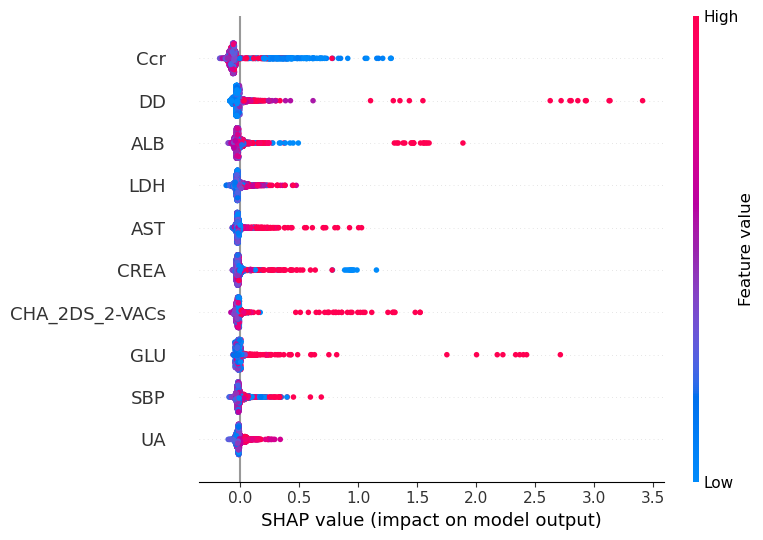

In [24]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values3,X_train,plot_type="dot",max_display=10,show=False)

In [25]:
get_shap_top_n(shap_values3,10)

array(['Ccr', 'DD', 'ALB', 'LDH', 'AST', 'CREA', 'CHA_2DS_2-VACs', 'GLU',
       'SBP', 'UA'], dtype=object)